In [1]:
import numpy as np
import pandas as pd
import pickle
import smogn

import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


In [3]:
df = pd.read_csv(r"/Users/admin/Desktop/optimization-1/parklane_combined_edited.csv")
print('Unfiltered row of dataframe is {}'.format(len(df)))

Unfiltered row of dataframe is 727657


### This notebook focus will be on predicting ch_sysef using various features and some selections of models

total number of rows after filter is 176037


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

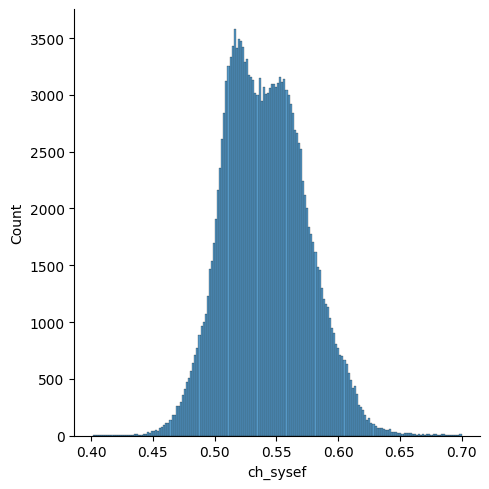

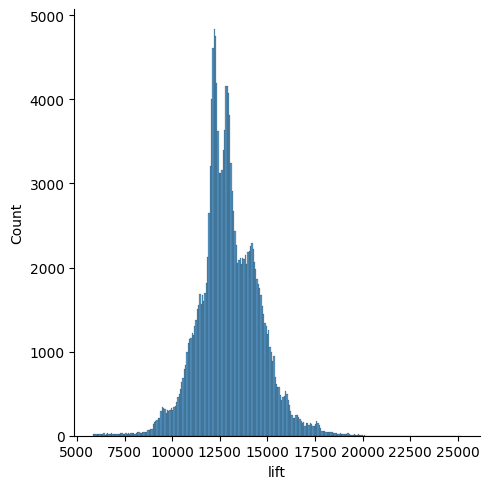

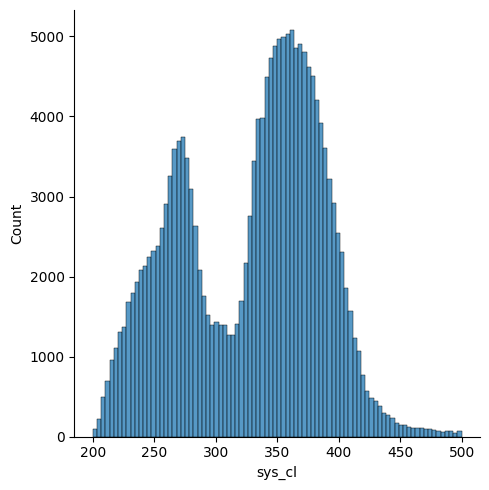

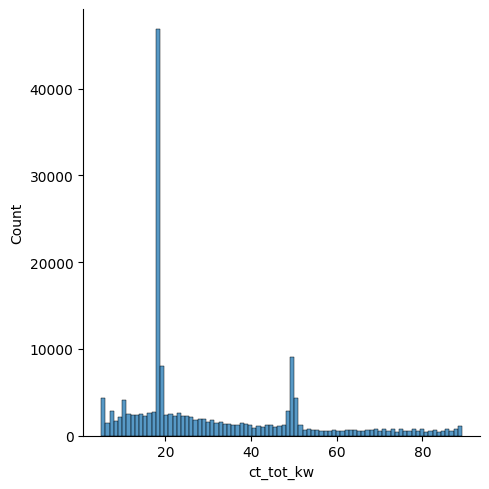

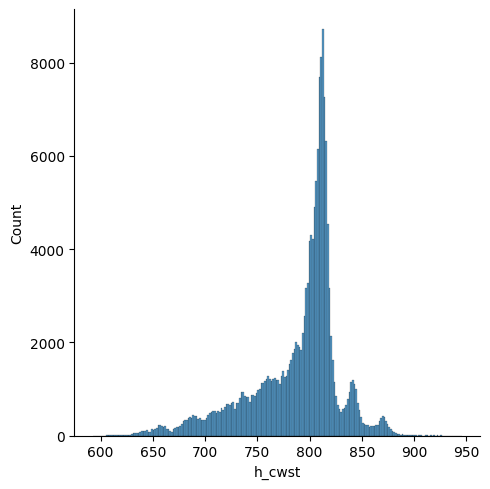

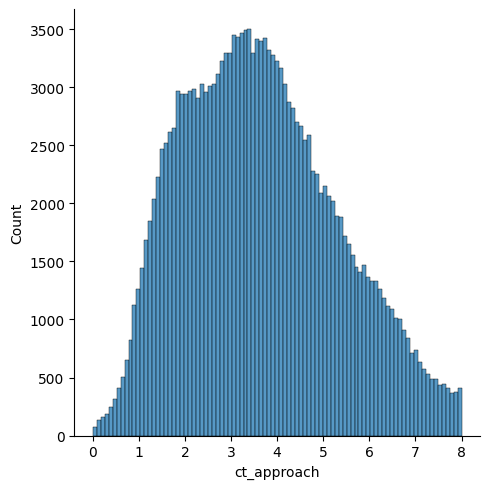

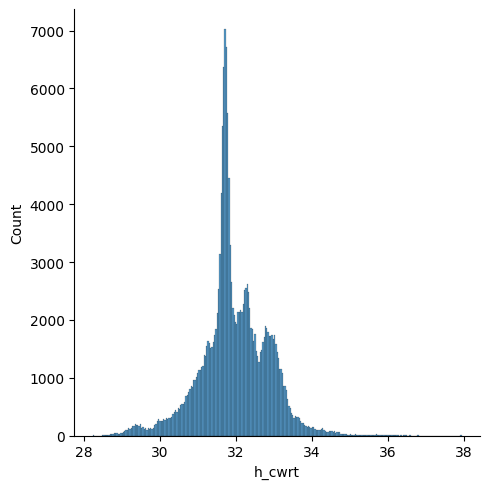

In [5]:
# filter where hr or hb is  not 0
df = df[(df['sys_hr'] != 0) | (df['sys_hb'] != 0)]
df = df[(df['h_chwst'] >=5) & (df['h_chwst'] <=20)]
df = df[(df['h_chwrt'] >=5) & (df['h_chwrt'] <=25)]
df = df[(df['pchwp_1_kw'] >=1.2) & (df['pchwp_1_kw'] <=5)]
# unsure of pchwp_2 kw filtering
#df = df[(df['pchwp_2_kw'] >=1.2) & (df['pchwp_2_kw'] <=5)]
df = df[(df['h_chwf'] >= 0) & (df['h_chwf'] <= 1500)]
df = df[(df['cwp_1_kw'] > 0) & (df['cwp_1_kw'] <=25)]
df = df[(df['cwp_2_kw'] > 0) & (df['cwp_2_kw'] <=25)]
df = df[(df['h_chwf'] >0) & (df['h_chwf'] <=1500)]
df = df[(df['h_cwst']>=20) & (df['h_cwst']<=32)]
df = df[(df['h_cwrt']>=20) & (df['h_cwrt']<=40)]
df = df[(df['ch_1_kwe']>=0) & (df['ch_1_kwe']<=350)]
df = df[(df['ch_2_kwe']>=0) & (df['ch_2_kwe']<=350)]
df = df[(df['ct_1_kw']>=0) & (df['ct_1_kw']<=15)]
df = df[(df['ct_2_kw']>=0) & (df['ct_2_kw']<=15)]
df = df[(df['sys_cl']>=200) & (df['sys_cl']<=500)]
df = df[(df['sys_hr']>0) & (df['sys_hr']<=1000)]
df = df[(df['sys_kw']>0) & (df['sys_kw']<=400)]
fil_df = df[(df['ch_sysef']>=0.4) & (df['ch_sysef']<=0.7) & (df['sys_eff']>=0.4) & (df['sys_eff']<=0.9)]

# replace NaN values with 0? median imputation
fil_df = fil_df.fillna(0)

# efficiency column reduce by air system efficiency
fil_df['sys_eff'] = fil_df['sys_eff'] - fil_df['air_eff']

# creating Lift Column, Lift: [h_cwrt-h_chwst]
fil_df['lift'] = fil_df['h_cwrt'] - fil_df['h_chwst']
fil_df = fil_df[(fil_df['lift']>=18) & (fil_df['lift']<=30)]

# chiller configuration
fil_df['ch_run'] = (fil_df['ch_1_kwe']>=2) & (fil_df['ch_2_kwe']>=2)
fil_df['ch_run'] = fil_df['ch_run'].astype(int)

# ct approach
fil_df['ct_approach'] = fil_df['h_cwst'] - fil_df['wea_ct_wb']
fil_df = fil_df[fil_df['ct_approach']<=4]

# ct_tot_kw
fil_df['ct_tot_kw'] = fil_df['ct_1_kw'] + fil_df['ct_2_kw']
fil_df = fil_df[(fil_df['ct_tot_kw']>=2) & (fil_df['ct_tot_kw']<=20)]

print("total number of rows after filter is {}".format(len(fil_df)))

# columns manipulation
# fil_df['ch_sysef'] = 1000 ** fil_df['ch_sysef']
fil_df['h_cwst'] = fil_df['h_cwst'] ** 2
fil_df['ct_approach'] = fil_df['ct_approach'] ** 1.5
fil_df['lift'] = fil_df['lift'] ** 3
fil_df['ct_tot_kw'] = fil_df['ct_tot_kw'] ** 1.5

# selecting related features only
ch_sysef_df = fil_df[['ch_sysef', 'lift', 'sys_cl', 'h_cwrt', 'ct_tot_kw', 'ch_run', 'h_cwst', 'ct_approach']]
# reset
ch_sysef_df = ch_sysef_df.reset_index()

# distribution
sns.displot(ch_sysef_df, x="ch_sysef")
sns.displot(ch_sysef_df, x="lift")
sns.displot(ch_sysef_df, x="sys_cl")
sns.displot(ch_sysef_df, x="ct_tot_kw")
sns.displot(ch_sysef_df, x="h_cwst")
sns.displot(ch_sysef_df, x="ct_approach")
sns.displot(ch_sysef_df, x="h_cwrt")

In [ ]:
ch_sysef_df['ch_run'].describe()

count    176037.000000
mean          0.412277
std           0.492246
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: ch_run, dtype: float64

In [ ]:
ch_sysef_df = ch_sysef_df.dropna()

## Training

In [6]:
# train_test split
X = ch_sysef_df[['lift', 'ct_tot_kw', 'ch_run', 'h_cwrt',]]
y = ch_sysef_df[['ch_sysef']]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
y.transpose()

# Training
max_depth = [100, 500]
min_samples_splits = [10, 25, 50]
no_of_trees = [100, 200, 500]
min_samples_leafs = [10, 25, 50]


parameter_grid = {
    'regressor__max_depth': max_depth,
    'regressor__min_samples_split': min_samples_splits,
    'regressor__min_samples_leaf': min_samples_leafs,
    'regressor__n_estimators': no_of_trees,
    'regressor__random_state': [10],

}

# pipeline
pipeline = Pipeline([
    ('regressor', RandomForestRegressor(
        warm_start=True,
        bootstrap=True,
        n_jobs=-1,
        max_features='sqrt'
    ))
])

grid_search = GridSearchCV(
    estimator= pipeline,
    param_grid=parameter_grid,
    cv=5
)

grid_search.fit(X_train, y_train)

## save model
filename = 'RF_h_cwrt.sav'
pickle.dump(grid_search, open(filename, 'wb'))

/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,),

In [ ]:
ch_sysef_df[ch_sysef_df.ch_run==1]

,index,ch_sysef,lift,sys_cl,ct_tot_kw,ch_run,h_cwst,ct_approach
72797,260230,46.843140,11529.216431,420.189697,84.551206,1,784.333796,2.851747
72798,260231,47.074422,11430.760974,417.514465,73.836155,1,783.457510,2.697698
72799,260232,41.554398,11500.634050,425.702484,63.808108,1,786.248049,2.964337
72800,260233,43.304198,11430.598087,418.937927,57.399021,1,791.367339,3.162868
72801,260234,41.307984,11545.791800,425.491486,51.398522,1,791.527583,3.414228
...,...,...,...,...,...,...,...,...
176032,727422,42.263066,11200.003241,265.164551,8.978951,1,805.065490,4.943831
176033,727423,34.288225,12298.162729,265.522705,8.632043,1,812.051481,5.210201
176034,727424,58.072430,11820.254905,225.187408,8.582858,1,807.985344,5.025551
176035,727425,42.457068,11157.250138,267.445557,8.289721,1,810.504914,5.109009


In [ ]:
X = ch_sysef_df[['lift', 'sys_cl', 'ct_tot_kw', 'ch_run', 'h_cwst', 'ct_approach']]
y = ch_sysef_df[['ch_sysef']]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
y.transpose()

,0,1,2,3,4,5,6,7,8,9,...,176027,176028,176029,176030,176031,176032,176033,176034,176035,176036
ch_sysef,31.069982,44.974257,51.318387,51.324769,52.240461,57.242817,60.551653,59.319571,57.478179,58.946633,...,26.221347,44.533415,43.315267,27.279098,57.674654,42.263066,34.288225,58.07243,42.457068,21.087835


In [ ]:
y_test.iloc[0]

ch_sysef    30.816478
Name: 11840, dtype: float64

In [ ]:
scaler_model = pickle.load(open(r"C:\Users\fabian\Desktop\optimization\optimization\parklane\RF_h_cwst_ct_approach_scaler.sav","rb"))
model = pickle.load(open(r"C:\Users\fabian\Desktop\optimization\optimization\parklane\RF_h_cwst_ct_approach.sav","rb"))

from sklearn.metrics import mean_squared_error

scaler_error = np.sqrt(mean_squared_error(y_test, scaler_model.predict(X_test)))
error = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))



C:\Users\fabian\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\fabian\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\fabian\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\fabian\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be rem

In [ ]:
X_test.head(5)

,lift,sys_cl,ct_tot_kw,ch_run,h_cwst,ct_approach
11840,10614.664983,309.855560,18.806734,0,663.197385,6.278951
64524,13572.950031,343.521851,18.425098,0,738.867485,6.257807
139260,12768.529046,348.145447,14.287351,1,810.993181,3.229825
153388,12059.724581,339.590424,23.241098,1,811.481423,5.143402
76055,11024.036321,284.129730,13.997160,1,804.255682,2.906462


In [ ]:
y_test.head(5)

,ch_sysef
11840,30.816478
64524,44.545722
139260,37.227168
153388,34.785880
76055,27.552372


In [ ]:
np.log10(model.predict([[22.6**3, 376, 5**3, 1, 29.7**2, 1.6**1.5]]))/3

C:\Users\fabian\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


array([0.5833504])

# Models varied by season

RH > 90% AND DB < 26 C as rainy days 
RH < 85% AND DB > 30C as hot days
other conditions as normal days? 